In [8]:
from glob import glob
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [9]:
path = "./Desktop/click/"
img_list = glob(os.path.join(path, "*.jpg"))


In [10]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=1,
    static_image_mode=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.1)

[[[104 101  96]
  [111 108 103]
  [110 110 102]
  ...
  [123 107 108]
  [122 106 107]
  [119 105 105]]

 [[107 104  99]
  [111 108 103]
  [110 110 102]
  ...
  [127 111 112]
  [123 109 109]
  [122 108 108]]

 [[111 108 103]
  [113 110 105]
  [115 112 107]
  ...
  [130 114 114]
  [127 113 112]
  [124 113 111]]

 ...

 [[ 90  95  98]
  [ 93  97 100]
  [ 98  99 103]
  ...
  [186 186 186]
  [185 187 184]
  [185 187 184]]

 [[ 87  90  95]
  [ 90  93  98]
  [ 96  97 102]
  ...
  [189 189 189]
  [186 188 187]
  [185 187 186]]

 [[ 85  88  93]
  [ 89  92  97]
  [ 95  94 102]
  ...
  [189 189 189]
  [187 189 188]
  [185 187 186]]]
Detection failed!


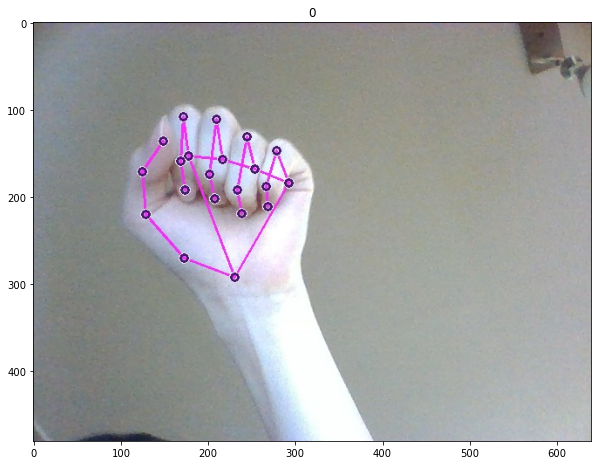

In [11]:
img_path = img_list[3]
img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = hands.process(img)
print(img)
data = None

if result.multi_hand_landmarks is not None:
    for res in result.multi_hand_landmarks:
        joint = np.zeros((21, 3))
        for j, lm in enumerate(res.landmark):
            joint[j] = [lm.x, lm.y, lm.z]

        # Compute angles between joints
        v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
        v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
        v = v2 - v1 # [20,3]
        # Normalize v
        v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

        # Get angle using arcos of dot product
        angle = np.arccos(np.einsum('nt,nt->n',
            v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
            v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

        angle = np.degrees(angle) # Convert radian to degree

        data = np.array([angle], dtype=np.float32)
        
        print(data)
        
        mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)
else:
    print('Detection failed!')

plt.figure(figsize=(10, 10))
plt.title(os.path.basename(img_path)[0])
plt.imshow(img)

In [12]:

classes = [
    '5click'
]

data_list = []

for img_path in tqdm(img_list):
    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)

    data = None
    label = None

    if result.multi_hand_landmarks is not None:
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 3))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]

            # Compute angles between joints
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
            v = v2 - v1 # [20,3]
            # Normalize v
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # Convert radian to degree

            data = np.array([angle], dtype=np.float32)
            label_id = classes.index('5click')
            
            data = np.append(data, label_id)
            
            data_list.append(data)
            
print(len(data_list))

100%|██████████| 413/413 [00:15<00:00, 25.97it/s]

47


In [13]:
np.savetxt('handtrain10.csv', data_list, delimiter=',')